## Создадим датасет

### Начальная установка

Установим необходимые завсимости

In [1]:
# %pip install PySpice

In [2]:
# %conda install -c conda-forge ngspice-exe

In [3]:
# %conda install -c conda-forge ngspice

In [4]:
# %conda install -c conda-forge ngspice-lib

### Необходимый импорт

In [5]:
import numpy as np
import pandas as pd

np.random.seed(0)

In [2]:
import os
from tqdm import tqdm # для progress bar

In [7]:
####################################################################################################

import matplotlib.pyplot as plt
%matplotlib inline

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

####################################################################################################

In [8]:
# %matplotlib notebook

Промоделируем работу MOSFET транзистора

In [16]:
spice_library = SpiceLibrary("D:/JUPYTER/MyAnacondaProject/example/libraries")

In [17]:
for key in spice_library.models:
    print(key)

ami05nfet
ami05pfet
tsmc018nfet
tsmc018pfet
pfet
BAV21
BAV21@xyce
2n2222a
ptm32nm_nmos
ptm32nm_pmos
ptm65nm_nmos
ptm65nm_pmos


In [18]:
for key in spice_library.subcircuits:
    print(key)

QS6K1
1N5822
1N4148
d1n5919brl
irf150
LMV981


In [19]:
def mos_circuit(params=None, noise=False):
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    
    circuit.include(spice_library['tsmc018nfet'])
    
    if noise:
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', 
                       l=d['length'] * np.random.normal(1, 0.1 / 3), 
                       w=d['width'] * np.random.normal(1, 0.1 / 3),)
    else:
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'],)

    return circuit

print(mos_circuit())

.title MOS circuit
.include D:\JUPYTER\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [9]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range, noise=False):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s}, noise=noise)
        
        if second_source_name == 'temp':
            simulator = circuit.simulator(temperature=s, normal_temperature=25)
        else:
            simulator = circuit.simulator(temperature=25, normal_temperature=25)
            
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        vd = - np.array(analysis.branches['vd'])
        if noise:
            y.append(vd * np.random.normal(1, 0.08 / 3, len(vd)))
        else:
            y.append(vd)
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [10]:
def plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_x=lambda x: x, func_y=lambda y: y):
    y = np.array(y)
    y = np.where(y <= 0, 1e-15, y)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
    for i, s in enumerate(second_source_range):
        ax.plot(func_x(x), func_y(y[i]), label=f'{second_source_name} = {str(s)}V')
    
    ax.legend()
    plt.show()

### Id and Vds

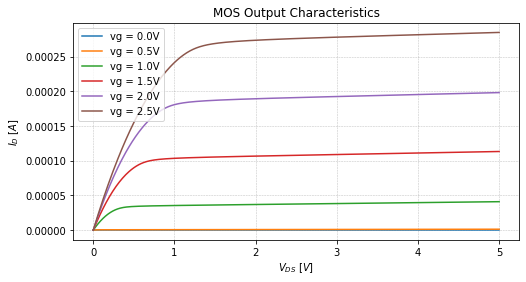

In [10]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

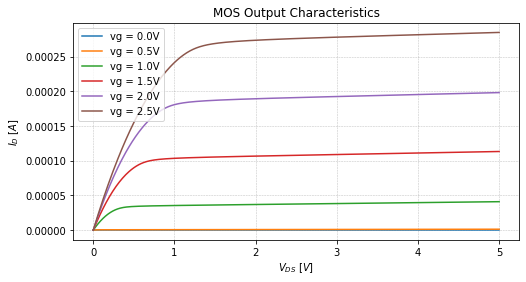

In [15]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

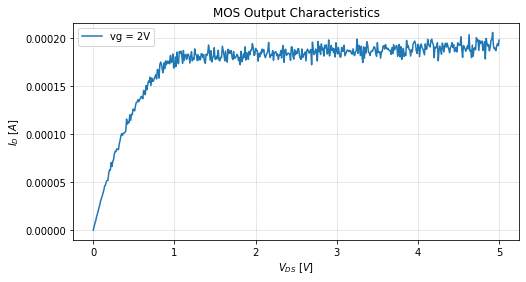

In [16]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
a = [2] * 1
second_source_range = np.array(a)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range, noise=True)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

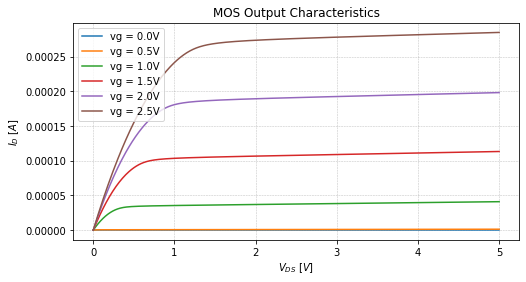

In [17]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

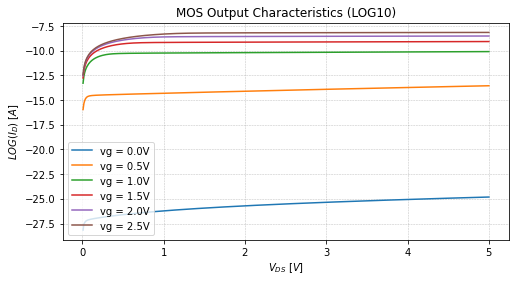

In [18]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$LOG(I_{D})\ [A]$'
title = 'MOS Output Characteristics (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

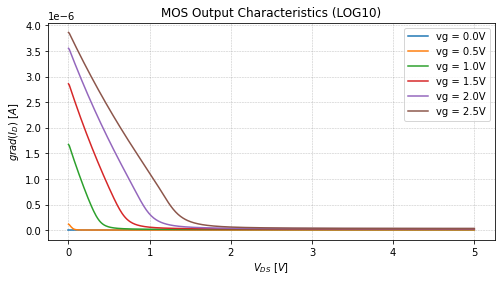

In [19]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$grad(I_{D})\ [A]$'
title = 'MOS Output Characteristics (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.gradient)

### Id and Vgs

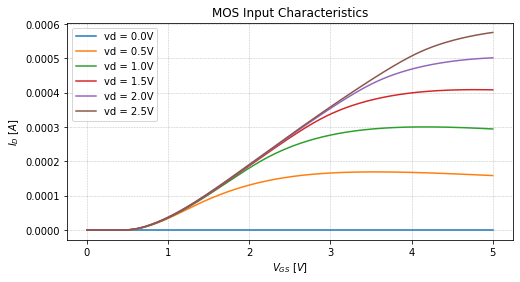

In [20]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

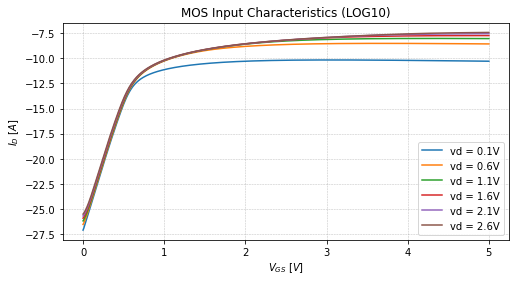

In [21]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .01)
second_source_name = 'vd'
second_source_range = np.arange(0.1, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

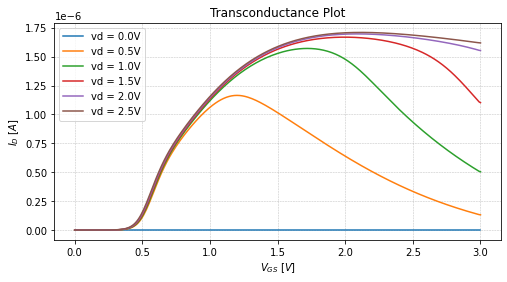

In [22]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.gradient)

### Id and W/L

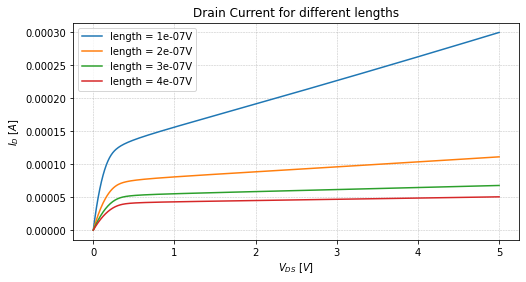

In [23]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-7

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

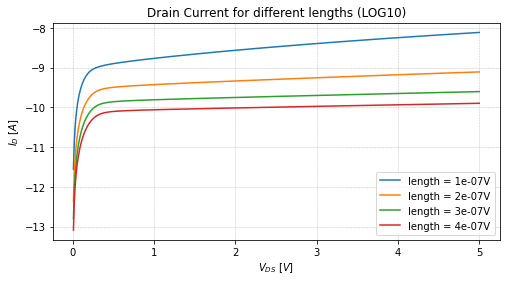

In [24]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-7

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

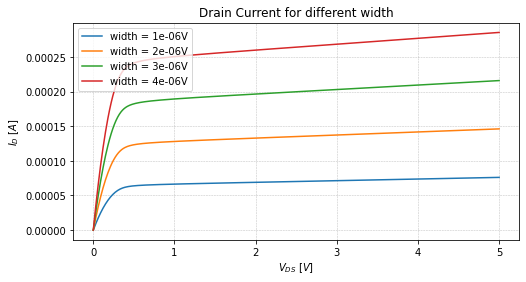

In [25]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

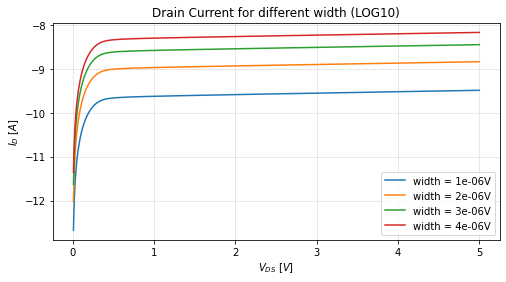

In [26]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width (LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=np.log)

### Id and T

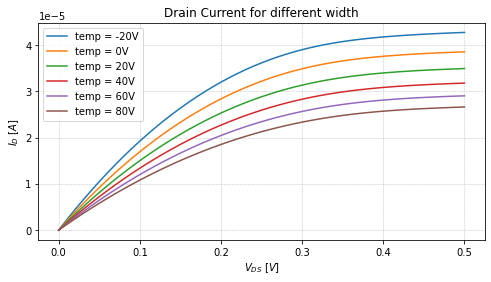

In [27]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'temp'
second_source_range = np.arange(-20, 100, 20)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

### Other

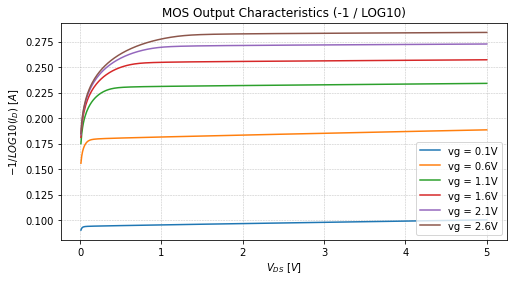

In [28]:
first_source_name = 'vd'
first_source_range = slice(0.01, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0.1, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$-1 / LOG10(I_{D})\ [A]$'
title = 'MOS Output Characteristics (-1 / LOG10)'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, func_y=lambda y: -1 / np.log10(y))

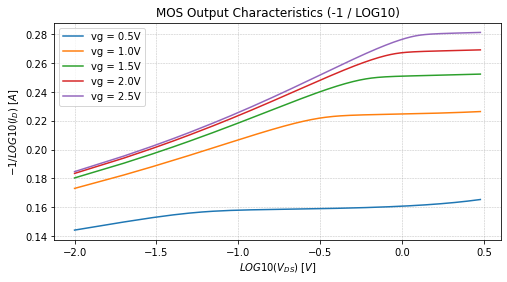

In [29]:
first_source_name = 'vd'
first_source_range = slice(0.01, 3, .01)
second_source_name = 'vg'
second_source_range = np.arange(0.5, 3, 0.5)
x_label = '$LOG10(V_{DS})\ [V]$'
y_label = '$-1 / LOG10(I_{D})\ [A]$'
title = 'MOS Output Characteristics (-1 / LOG10)'

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

plot(x_label, y_label, title, x, y, second_source_name, second_source_range, 
     func_x=np.log10, func_y=lambda y: -1 / np.log10(y))

In [30]:
def func_3d(vd_slice, vg_range):
    dataset = {'Vds': [], 'Vgs': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    Id = np.array([])
    
    for vg in vg_range:
        circuit = mos_circuit({'vg':vg, })
        simulator = circuit.simulator(temperature=25, normal_temperature=25)
        analysis = simulator.dc(VD=vd_slice)
        
        id_range = (- np.array(analysis.branches['vd']))
        len_id = len(id_range)
        
        vd_range = np.arange(vd_slice.start, vd_slice.stop + vd_slice.step, vd_slice.step)
        
        Vds = np.hstack((Vds, vd_range))
        Vgs = np.hstack((Vgs, [vg] * len_id))
        Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['Id'] = Id.tolist()
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [106]:
%matplotlib notebook

<IPython.core.display.Javascript object>


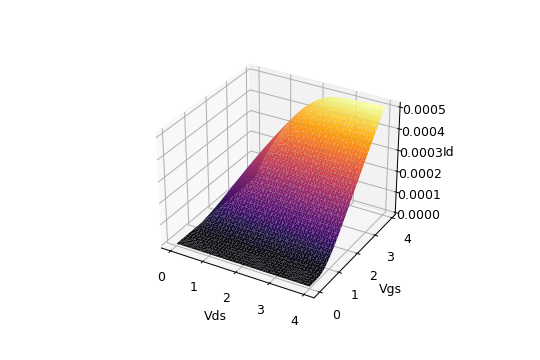

In [32]:
plot3d = func_3d(slice(0, 4, .1), np.arange(0, 4, 0.1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

# ax.view_init(elev=45, azim=0)

ax.plot_trisurf(plot3d['Vds'].to_numpy(), plot3d['Vgs'].to_numpy(), plot3d['Id'].to_numpy(), cmap='inferno')

<IPython.core.display.Javascript object>


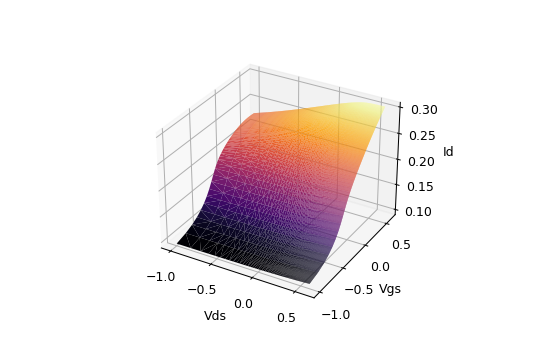

In [34]:
plot3d = func_3d(slice(0.1, 4, .05), np.arange(0.1, 4, .05))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

# Replace zeros
# plot3d["Id"].replace({0:1e-10}, inplace=True)
# plot3d["Vgs"].replace({0:1e-3}, inplace=True)
# plot3d["Vds"].replace({0:1e-3}, inplace=True)

# ax.view_init(elev=45, azim=0)

ax.plot_trisurf(np.log10(plot3d['Vds'].to_numpy()), 
                np.log10(plot3d['Vgs'].to_numpy()), 
                -1 / np.log10(plot3d['Id'].to_numpy()), cmap='inferno')

### Пороговое напряжение

$ V_{gs}(I_{ds} -> 0) = V_t + \frac{V_{ds}}{2}$  => $ V_{gs}(I_{ds} -> 0) = V_t$

In [363]:
def voltage_th(vg_range, vds, l, w, temp, noise=False):
#     промоделируем транзистор
    circuit = mos_circuit({'vd':vds, 'length': l, 'width': w, 'temp': temp}, noise=noise)
    simulator = circuit.simulator(temperature=temp, normal_temperature=25)
    analysis = simulator.dc(VG=vg_range)
    id_range = - np.array(analysis.branches['vd'])
    if noise:
        id_range = id_range * np.random.normal(1, 0.08 / 3, len(id_range))
    vg_range = np.array(analysis.nodes['vg'])
    
    id_max=max(id_range)
    
    x, y = [], []
    for i in range(len(id_range)):
        if id_range[i] >= id_max * 0.8:
            break
        elif id_range[i] >= id_max * 0.2:
            x.append(vg_range[i])
            y.append(id_range[i])
        
    #полином 1 степени по функции
    p = np.polyfit(x,y, 1)
#     print(p)
    
    return p, x

<IPython.core.display.Javascript object>


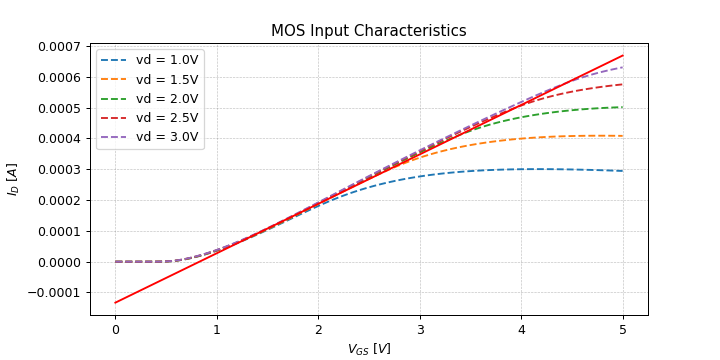

V_t для 1.0 V:  0.7840337833585307
V_t для 1.5 V:  0.8387082710348754
V_t для 2.0 V:  0.8475608600367501
V_t для 2.5 V:  0.8402078125666749
V_t для 3.0 V:  0.8286444437252495
Среднее значение порогового напряжения 0.8278310341444162


In [364]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .05)
second_source_name = 'vd'
second_source_range = np.arange(1, 3.3, 0.5)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics'

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

fig, ax = plt.subplots(figsize=(8, 4))
    
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
ans = []
l_a, l_b = [], []
for i, s in enumerate(second_source_range):
    ax.plot(x, y[i], '--', label=f'{second_source_name} = {str(s)}V',)
    
    p, x_ = voltage_th(first_source_range, s, 5e-7, 5e-7, 25)
#     ya = np.polyval(p, range(5))
#     ax.plot(range(5), ya)
    l_a.append(p[0])
    l_b.append(p[1])
    print(f'V_t для {s} V: ', -p[1]/p[0])
    ans.append(-p[1]/p[0])
    

Vt = np.mean(ans)
print("Среднее значение порогового напряжения", Vt)

ya = np.polyval([np.mean(l_a), np.mean(l_b)], range(6))
ax.plot(range(6), ya, 'r')
    
ax.legend()
plt.show()


<IPython.core.display.Javascript object>


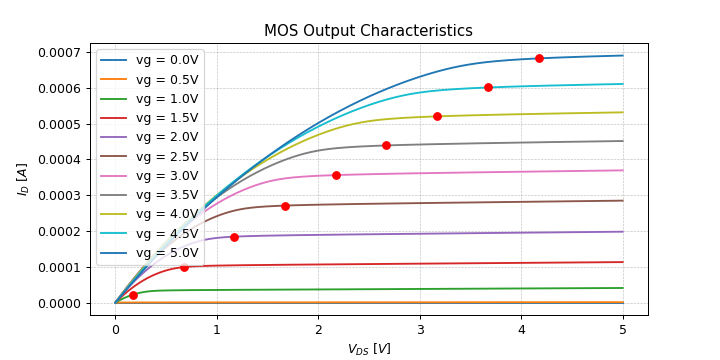

[0.17216897] [array([2.22552035e-05])]
[0.67216897] [array([9.92749255e-05])]
[1.17216897] [array([0.00018436])]
[1.67216897] [array([0.00027118])]
[2.17216897] [array([0.00035633])]
[2.67216897] [array([0.00043919])]
[3.17216897] [array([0.00052041])]
[3.67216897] [array([0.00060108])]
[4.17216897] [array([0.00068236])]


In [365]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 5.1, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

# plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

fig, ax = plt.subplots(figsize=(8, 4))
    
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
# Vt += 0.4
for i, s in enumerate(second_source_range):
    ax.plot(x, y[i], label=f'{second_source_name} = {str(s)}V')
    if s > Vt:
        x_, y_ = sweep_source(first_source_name, slice((s - Vt), (s - Vt) + 1, 10), second_source_name, [s, ])
        print(x_, y_)
        ax.plot(x_, y_, 'ro')


    
#     p, x_ = voltage_th(first_source_range, s, 5e-7, 5e-7, 25, noise=True)
#     ya = np.polyval(p, range(5))
#     ax.plot(range(5), ya)
#     print(f'V_t для {s} V: ', -p[1]/p[0])
#     ans.append(-p[1]/p[0])
    

# Vt = np.mean(ans)
# print("Среднее значение порогового напряжения", Vt)
    
ax.legend()
plt.show()

# Создание файлов с различными параметрами модели

In [203]:
NUM_FILES = 50

In [204]:
PATH = "C:/Users/lario/MyAnacondaProject/example/libraries"
spice_library = SpiceLibrary(PATH)

In [205]:
for key in spice_library.models:
    print(key)

ami05nfet
ami05pfet
tsmc018nfet
tsmc018pfet
pfet
BAV21
BAV21@xyce
2n2222a
ptm32nm_nmos
ptm32nm_pmos
ptm65nm_nmos
ptm65nm_pmos


In [206]:
with open(PATH + '/tsmc018(3).lib') as f:
    print(f.read())

*
.MODEL tsmc018nfet NMOS (                                LEVEL   = 49
+VERSION = 3.1            TNOM    = 27             TOX     = 4.1E-9
+XJ      = 1E-7           NCH     = 2.3549E17      VTH0    = 0.3669193
+K1      = 0.592797       K2      = 2.518108E-3    K3      = 1E-3
+K3B     = 4.7942179      W0      = 1E-7           NLX     = 1.745125E-7
+DVT0W   = 0              DVT1W   = 0              DVT2W   = 0
+DVT0    = 1.3683195      DVT1    = 0.4097438      DVT2    = 0.0552615
+U0      = 263.5112775    UA      = -1.363381E-9   UB      = 2.253823E-18
+UC      = 4.833037E-11   VSAT    = 1.017805E5     A0      = 1.9261289
+AGS     = 0.4192338      B0      = -1.069507E-8   B1      = -1E-7
+KETA    = -8.579587E-3   A1      = 2.789024E-4    A2      = 0.8916186
+RDSW    = 126.5291844    PRWG    = 0.4957859      PRWB    = -0.2
+WR      = 1              WINT    = 0              LINT    = 7.790316E-9
+XL      = -4E-8          XW      = 0              DWG     = -1.224589E-8
+DWB     = 1.579145E

In [207]:
# import os
# os.mkdir("tsmc018")

In [208]:
with open (PATH + '/tsmc018(3).lib', 'r') as f:
    old_data = f.read()

for i in range(NUM_FILES):
    new_data = old_data.replace('tsmc018nfet', f'tsmc018nfet_{i}')
    new_data = new_data.replace('+U0      = 263.5112775', f'+U0 = {263.5112775 * np.random.normal(1, 0.05)}')
    new_data = new_data.replace('VTH0    = 0.3669193', f'VTH0 = {0.3669193 * np.random.normal(1, 0.05)}')
    new_data = new_data.replace('VOFF    = -0.0895222', f'VOFF = {-0.0895222 * np.random.normal(1, 0.05)}')
    new_data = new_data.replace('KETA    = -8.579587E-3', f'KETA = {-8.579587E-3 * np.random.normal(1, 0.05)}')
    new_data = new_data.replace('TNOM    = 27', f'TNOM = {27 * np.random.normal(1, 0.05)}')

    with open (f'./tsmc018nfet/tsmc018_{i}.lib', 'w') as f:
        f.write(new_data)

In [209]:
spice_library = SpiceLibrary("C:/Users/lario/MyAnacondaProject/example/libraries")
spice_library_mod = SpiceLibrary("./tsmc018nfet")

In [210]:
# for key in spice_library_mod.models:
#     print(key)

In [211]:
def mos_circuit_mod(params=None, noise=False, mod=None):
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    
    if mod:
#         print('set mod')
#         mod = np.random.randint(NUM_FILES)
        circuit.include(spice_library_mod[f'tsmc018nfet_{mod}'])
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model=f'tsmc018nfet_{mod}', l=d['length'], w=d['width'],)
#         circuit.MOSFET(1, 'VD', 'VG', 0, 0, model=f'tsmc018nfet', l=d['length'], w=d['width'],)
    else:
#         print('set not mod')
        circuit.include(spice_library['tsmc018nfet'])
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'],)

    return circuit

print(mos_circuit())

.title MOS circuit
.include C:\Users\lario\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [212]:
def sweep_source_mod(first_source_name, first_source_range, second_source_name, second_source_range):
    y = []
    
    for mod in range(NUM_FILES):
#         print(f'MOD == {mod}')
        for mod in second_source_range:
            circuit = mos_circuit_mod(mod=mod)
        
            if second_source_name == 'temp':
                simulator = circuit.simulator(temperature=s, normal_temperature=25)
            else:
                simulator = circuit.simulator(temperature=25, normal_temperature=25)
            
            if first_source_name == 'vg':
                analysis = simulator.dc(VG=first_source_range)
            else:
                analysis = simulator.dc(VD=first_source_range)
            vd = - np.array(analysis.branches['vd'])
            y.append(vd)
      
    x = np.array(analysis.nodes[first_source_name])
    return x, y

<IPython.core.display.Javascript object>


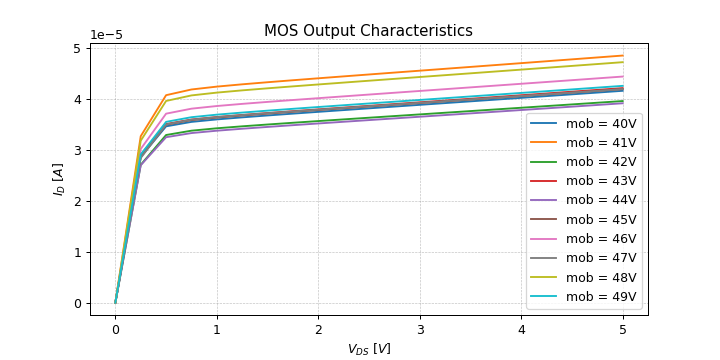

In [213]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .25)
second_source_name = 'mob'
# second_source_range = np.arange(NUM_FILES)
second_source_range = np.arange(40, 50)

x, y = sweep_source_mod(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, second_source_name, second_source_range)

## Датасет для нескольких параметров (Vds, Vgs, Length, Width, Temp)

In [11]:
spice_library = SpiceLibrary("C:/Users/lario/MyAnacondaProject/example/libraries")

In [12]:
class MOS_Circuit():
    """Класс для цепи с MOSFET транзистором
    
    !!! для использования с другими моделями изменить create_files_mob !!!
    
    """
    
    NUM_FILES = 50 # число для кол-ва файлов для различных подвижности
    PATH = "C:/Users/lario/MyAnacondaProject/example/libraries"                  # ИЗМЕНИТЬ КОД
    spice_library_mob = SpiceLibrary("./tsmc018nfet")                            # ИЗМЕНИТЬ КОД
    
    def __init__(self, model, noise_l=0, noise_w=0, noise_mob=0):
        """
        model : str - название модели
        
        noise_l, noise_w : int - шум для L(длина) и W(ширина) в долях (%)
        
        noise_mob : float - шум для подвижности (использование сгенерированных файлов)
        """
        self.model = model
        self.noise_l = noise_l
        self.noise_w = noise_w
        self.noise_mob = noise_mob
        self.default_params = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
        
        
    def _change_params(self, params):
        """Получаем изменения параметров, выдаем полный словарь параметров"""
        d = self.default_params
        if params is None:
            return d
        for k, v in params.items():
            d[k] = v
        return d
        
        
    def create_circuit(self, params=None):
        """Создание цепи для MoSFET"""
        self.circuit = Circuit('MOS circuit')
        self.params = self._change_params(params)
        
        self.circuit.V('G', 'VG', 0, self.params['vg'])
        self.circuit.V('D', 'VD', 0, self.params['vd'])
        
        if self.noise_mob == 0:                                       # глупо
            self.circuit.include(spice_library[self.model])
            self.circuit.MOSFET(
                1, 'VD', 'VG', 0, 0, model=self.model, 
                l=self.params['length'] * np.random.normal(1, self.noise_l), 
                w=self.params['width']  * np.random.normal(1, self.noise_w),
            ) 
        else:
            num = np.random.randint(self.NUM_FILES)
            
#             print('.', f'{self.model}_{num}', )
            
            self.circuit.include(self.spice_library_mob[f'{self.model}_{num}'])
            self.circuit.MOSFET(
                1, 'VD', 'VG', 0, 0, model=f'{self.model}_{num}', 
                l=self.params['length'] * np.random.normal(1, self.noise_l), 
                w=self.params['width']  * np.random.normal(1, self.noise_w),
            )
            
#         print(self.circuit)
        return self.circuit

    def create_files_mob(self):
        """Создание файлов с различным параметрами"""
        # открытие файла с моделью
        with open (self.PATH + '/tsmc018(3).lib', 'r') as f:  # ИЗМЕНИТЬ КОД
            old_data = f.read()
            
        if not os.path.exists(self.model):
            os.makedirs(self.model)
            
        # замена строки и создание нового файла
        for i in range(self.NUM_FILES):
            new_data = old_data.replace(self.model, f'{self.model}_{i}')
            
            old_str = '+U0      = 263.5112775'
            
            if new_data.find(old_str) == -1:
                print(f'Подстрока {old_str} не найдена !')
                return
            
#             new_data = new_data.replace('+U0      = 263.5112775',                                     # ИЗМЕНИТЬ КОД
#                                         f'+U0 = {263.5112775 * np.random.normal(1, self.noise_mob)}') # ИЗМЕНИТЬ КОД
            new_data = new_data.replace('U0      = 263.5112775', f'U0 = {263.5112775 * np.random.normal(1, self.noise_mob)}')
            new_data = new_data.replace('VTH0    = 0.3669193', f'VTH0 = {0.3669193 * np.random.normal(1, self.noise_mob)}')
            new_data = new_data.replace('VOFF    = -0.0895222', f'VOFF = {-0.0895222 * np.random.normal(1, self.noise_mob)}')
            new_data = new_data.replace('KETA    = -8.579587E-3', f'KETA = {-8.579587E-3 * np.random.normal(1, self.noise_mob)}')
            new_data = new_data.replace('TNOM    = 27', f'TNOM = {27 * np.random.normal(1, 0.05)}')

            with open (f'./{self.model}/{self.model}_{i}.lib', 'w') as f:
                f.write(new_data)
                
    def list_of_models(self):
        return [key for key in self.spice_library_mob.models]

In [13]:
nfet = MOS_Circuit('tsmc018nfet')
nfet.create_circuit()

In [14]:
class Database(MOS_Circuit):
    """Класс для создания датасета"""
    
#     NUM_FILES = 50 # число для кол-ва файлов для различных подвижности
#     PATH = "C:/Users/lario/MyAnacondaProject/example/libraries"                  # ИЗМЕНИТЬ КОД
#     spice_library_mod = SpiceLibrary("./tsmc018")                                # ИЗМЕНИТЬ КОД
    
    def __init__(self, model, vd_slice, vg_range, l_range, w_range, t_range, 
                 noise_l=0, noise_w=0, noise_id=0, noise_mob=0):
        """
        model : str - название модели
        
        vd_slice : slice - точки на V_ds
        vg_range : range - точки на V_gs
        l_range  : range - точки на L (длина)
        w_range  : range - точки на W (ширина)
        t_range  : range - точки на T (температура)
        
        noise_l   : float - шум для L(длина) в долях (%)
        noise_w   : float
        noise_id  : float
        
        noise_mob : float - шум для подвижности (использование сгенерированных файлов)
        """
        super().__init__(model, noise_l, noise_w, noise_mob)
        self.data = { i: np.array([]) for i in ['Vds', 'Vgs', 'L', 'W', 'T', 'Id'] }
        self.noise_id = noise_id
        self.vd_slice = vd_slice
        self.vg_range = vg_range
        self.l_range = l_range
        self.w_range = w_range
        self.t_range = t_range
    
    
    def _next_params(self):
        """генератор для параметров"""
        for vg in self.vg_range:
            for l in self.l_range:
                for w in self.w_range:
                    for t in self.t_range:
                        yield vg, l, w, t
                        
                        
    def modeling_circuit(self, vg, l, w, temp):
        """Моделирование цепи, получение ВАХ (при Vgs == const)
        vg, l, w, temp : float - параметры цепи
        
        return: id_range - значения тока
        """
        self.circuit = self.create_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp})
        simulator = self.circuit.simulator(temperature=temp, normal_temperature=25)
        analysis = simulator.dc(VD=self.vd_slice)
        id_range = (- np.array(analysis.branches['vd']))
        id_range = id_range * np.random.normal(1, self.noise_id, len(id_range))
        return id_range
    
    def get_vd_range(self):
        vd_range = np.arange(self.vd_slice.start, self.vd_slice.stop, self.vd_slice.step)
        return vd_range
        
        
    def create_dataset(self, num_of_meas=1):
        """Создание датасета
        num_of_meas : int - число посторений измерений
        
        return : DataFrame - датасет (pandas file)?
        """
        len_params = len(self.vg_range) * len(self.l_range) * len(self.w_range) * len(self.t_range)
#         print(len(self.vg_range), len(self.l_range), len(self.w_range), len(self.t_range))
        params = self._next_params()
        
        for _ in tqdm(range(len_params)):
            vg, l, w, temp = next(params)
            
            for _ in range(num_of_meas):
                id_range = self.modeling_circuit(vg, l, w, temp)
                    
                vd_range = self.get_vd_range()
            
                len_id = len(id_range)
                
#                 print(len(vd_range), len_id, len(id_range))
                
                self.data['Vds'] = np.hstack((self.data['Vds'], vd_range))
                self.data['Vgs'] = np.hstack((self.data['Vgs'], [vg] * len_id))
                self.data['L']   = np.hstack((self.data['L'],   [l] * len_id))
                self.data['W']   = np.hstack((self.data['W'],   [w] * len_id))
                self.data['T']   = np.hstack((self.data['T'],   [temp] * len_id))
                self.data['Id']  = np.hstack((self.data['Id'],  id_range))

        self.data['Vds'] = self.data['Vds'].tolist()
        self.data['Vgs'] = self.data['Vgs'].tolist()
        self.data['L']   = self.data['L'].tolist()
        self.data['W']   = self.data['W'].tolist()
        self.data['T']   = self.data['T'].tolist()
        self.data['Id']  = self.data['Id'].tolist()
        
        return self.data_to_pandas()
    
    def data_to_pandas(self):
        """Получение датасета в виде pandas file"""
#         print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        return pd.DataFrame(self.data, index=None)
    
    def to_csv(self, file_name):
        self.data_to_pandas().to_csv(file_name, index=None)
        print(f'Save as {file_name}')

### Простой датасет

In [61]:
database_simple = Database(
    model='tsmc018nfet',
    vd_slice = slice(0, 3.1, .25),
    vg_range = np.arange(0, 3.1, .25),
    l_range  = np.array([200e-9, 400e-9, 1000e-9]),
    w_range  = np.array([200e-9, 400e-9, 1000e-9]), 
    t_range  = np.arange(0, 51, 25),
#     noise_mob = 0.05,
)
database_simple.create_dataset()
database_simple.to_csv('mosfet_simple.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 362.38it/s]

Save as mosfet_simple.csv


In [62]:
db = database_simple.data_to_pandas()
# db
db[(db['L'] == 2e-7) & (db['W'] == 2e-7) & (db['T'] == 0)]

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,6.993572e-13
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.252304e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,1.814132e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.387202e-12
...,...,...,...,...,...,...
4220,2.00,3.0,2.000000e-07,2.000000e-07,0.0,4.077205e-04
4221,2.25,3.0,2.000000e-07,2.000000e-07,0.0,4.108984e-04
4222,2.50,3.0,2.000000e-07,2.000000e-07,0.0,4.138433e-04
4223,2.75,3.0,2.000000e-07,2.000000e-07,0.0,4.166475e-04


Построим ВАХ

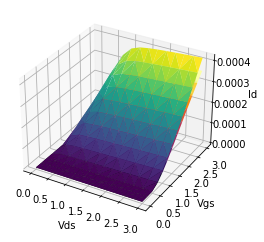

In [63]:
df = database_simple.data_to_pandas()
plot3d = db[(db['L'] == 4e-7) & (db['W'] == 4e-7) & (db['T'] == 0)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

ax.plot_trisurf(plot3d['Vds'], 
                plot3d['Vgs'], 
                plot3d['Id'], cmap='inferno')

plot3d = db[(db['L'] == 2e-7) & (db['W'] == 2e-7) & (db['T'] == 0)]

ax.plot_trisurf(plot3d['Vds'], 
                plot3d['Vgs'], 
                plot3d['Id'], cmap ="viridis", color ="red")

In [386]:
def plot(x_label, y_label, title, x, y, 
         second_source_name, second_source_range, 
         func_x=lambda x: x, func_y=lambda y: y, 
         old_y=None
        ):
    y = np.array(y)
    y = np.where(y <= 0, 1e-15, y)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
    for i, s in enumerate(second_source_range):
        ax.plot(func_x(x), func_y(y[i]), label=f'{second_source_name} = {str(s)}V')
        
    if old_y != None:
        for i, s in enumerate(second_source_range):
            ax.plot(func_x(x), func_y(old_y[i]), label=f'OLD {second_source_name} = {str(s)}V')
    
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


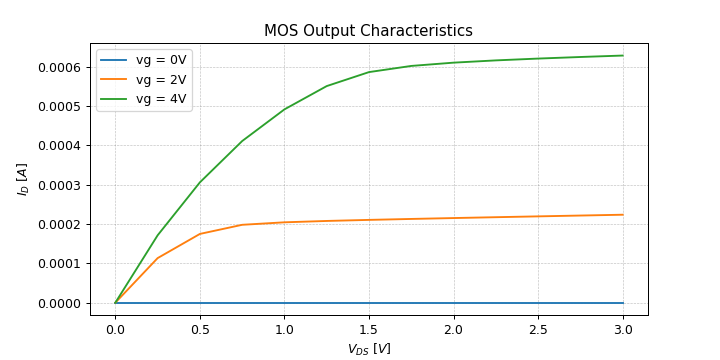

In [387]:
x = database_simple.get_vd_range()
y = []
vg_range = [0, 2, 4]

for vg in vg_range:
    y.append(database_simple.modeling_circuit(vg = vg, l = 2e-7, w = 2e-7, temp=0))

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, 'vg', vg_range)

In [388]:
df['Vgs'].unique()

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  ])

In [389]:
df['L'].unique()

array([2.e-07, 4.e-07, 1.e-06])

In [390]:
df['W'].unique()

array([2.e-07, 4.e-07, 1.e-06])

In [391]:
df['T'].unique()

array([ 0., 25., 50.])

<IPython.core.display.Javascript object>


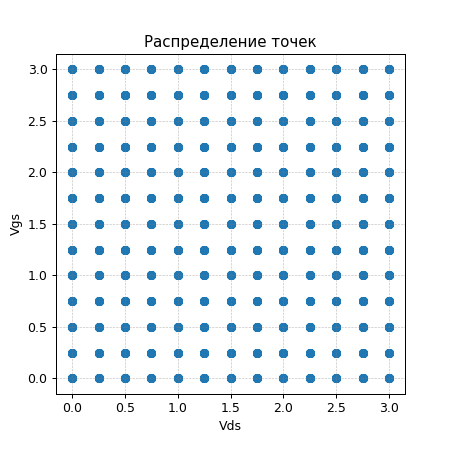

In [392]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


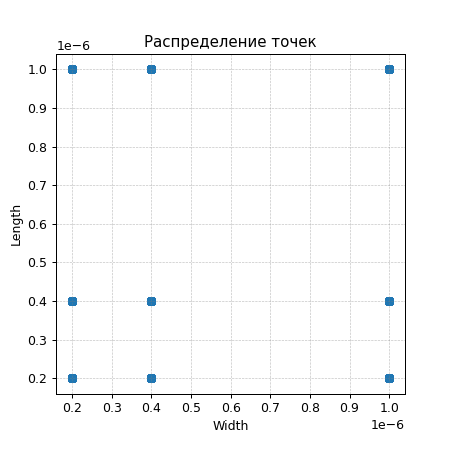

In [393]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

### Датасет с шумом во внутренних параметрах (подвижность)

In [394]:
database_mod = Database(
    model='tsmc018nfet',
    vd_slice = slice(0, 3.1, .25),
    vg_range = np.arange(0, 3.1, .25),
    l_range  = np.array([200e-9, 400e-9, 1000e-9]),
    w_range  = np.array([200e-9, 400e-9, 1000e-9]), 
    t_range  = np.arange(0, 51, 25),
    noise_mob = 0.1,
)
# database_mod.create_files_mob()
# print(database_mod.list_of_models())
database_mod.create_dataset()
database_mod.to_csv('mosfet_mob.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:02<00:00, 127.71it/s]

Save as mosfet_mob.csv


In [395]:
database_mod.data_to_pandas()

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-7.969457e-29
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,8.280737e-13
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.415437e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,2.017470e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.637973e-12
...,...,...,...,...,...,...
4558,2.00,3.0,1.000000e-06,1.000000e-06,50.0,3.927031e-04
4559,2.25,3.0,1.000000e-06,1.000000e-06,50.0,3.983362e-04
4560,2.50,3.0,1.000000e-06,1.000000e-06,50.0,4.010206e-04
4561,2.75,3.0,1.000000e-06,1.000000e-06,50.0,4.027528e-04


Построим ВАХ

<IPython.core.display.Javascript object>


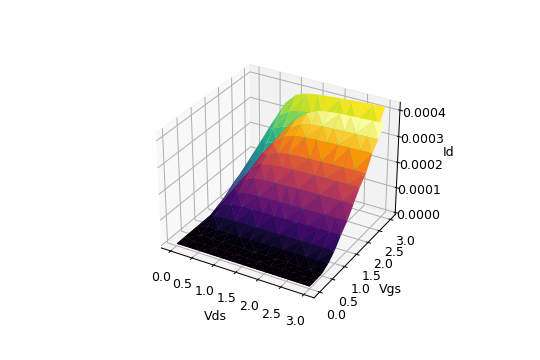

In [396]:
db = database_mod.data_to_pandas()

plot3d = db[(db['L'] == 4e-7) & (db['W'] == 4e-7) & (db['T'] == 0)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

ax.plot_trisurf(plot3d['Vds'], 
                plot3d['Vgs'], 
                plot3d['Id'], cmap='inferno')

plot3d = db[(db['L'] == 2e-7) & (db['W'] == 2e-7) & (db['T'] == 0)]

ax.plot_trisurf(plot3d['Vds'], 
                plot3d['Vgs'], 
                plot3d['Id'], cmap ="viridis", color ="red")

<IPython.core.display.Javascript object>


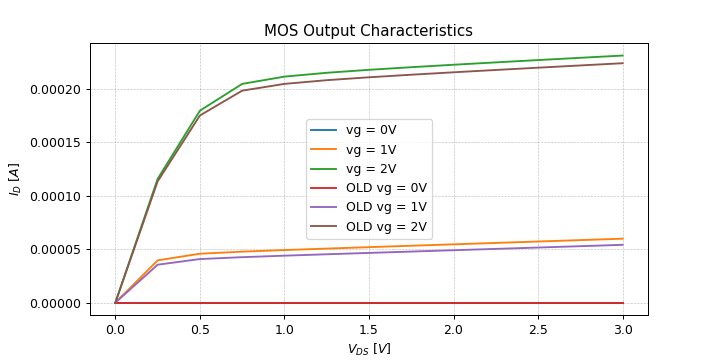

In [398]:
x = database_mod.get_vd_range()
y = []
old_y = []
vg_range = [0, 1, 2]

for vg in vg_range:
    y.append(database_mod.modeling_circuit(vg = vg, l = 2e-7, w = 2e-7, temp=0))
    old_y.append(database_simple.modeling_circuit(vg = vg, l = 2e-7, w = 2e-7, temp=0))

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, 'vg', vg_range, old_y=old_y)

<IPython.core.display.Javascript object>


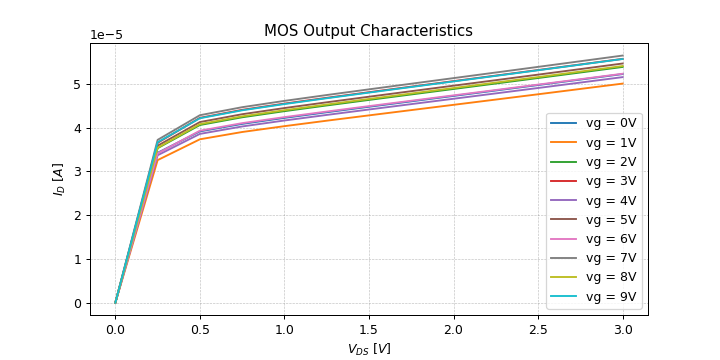

In [399]:
x = database_mod.get_vd_range()
y = []

for i in range(10):
    y.append(database_mod.modeling_circuit(vg = 1, l = 2e-7, w = 2e-7, temp=0, ))

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, 'vg', range(10))

Посчитаем MSE для обычного датасета и с шумом в параметрах

In [400]:
from tensorflow.keras.losses import MSE
from tensorflow import reduce_mean

In [401]:
def print_loss(data1, data2):
    loss = MSE(data1['Id'], data2['Id'])
    print('max loss: ', np.max(loss))
    loss_mean = reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
    print('mean post-prox loss: ', loss_mean)

In [402]:
data1 = database_simple.data_to_pandas()
data2 = database_mod.data_to_pandas()

print_loss(data1, data2)

max loss:  3.9321009736695016e-11
mean post-prox loss:  tf.Tensor(3.9321009736695016e-11, shape=(), dtype=float64)


### Добавление в датасет шума во входных параметрах и выходных

In [403]:
database_noise = Database(
    model='tsmc018nfet',
    vd_slice = slice(0, 3.1, .25),
    vg_range = np.arange(0, 3.1, .25),
    l_range  = np.array([200e-9, 400e-9, 1000e-9]),
    w_range  = np.array([200e-9, 400e-9, 1000e-9]), 
    t_range  = np.arange(0, 51, 25),
    noise_l=0.03, noise_w=0.03, noise_id=0.03, noise_mob = 0.1
)
database_noise.create_dataset()
database_noise.to_csv('mosfet_noise.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 351/351 [00:02<00:00, 156.51it/s]

Save as mosfet_noise.csv


In [404]:
database_noise.data_to_pandas()

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-3.006235e-29
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,1.448325e-12
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.188836e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,1.648164e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.307082e-12
...,...,...,...,...,...,...
4558,2.00,3.0,1.000000e-06,1.000000e-06,50.0,4.498653e-04
4559,2.25,3.0,1.000000e-06,1.000000e-06,50.0,4.047690e-04
4560,2.50,3.0,1.000000e-06,1.000000e-06,50.0,4.230333e-04
4561,2.75,3.0,1.000000e-06,1.000000e-06,50.0,4.366977e-04


<IPython.core.display.Javascript object>


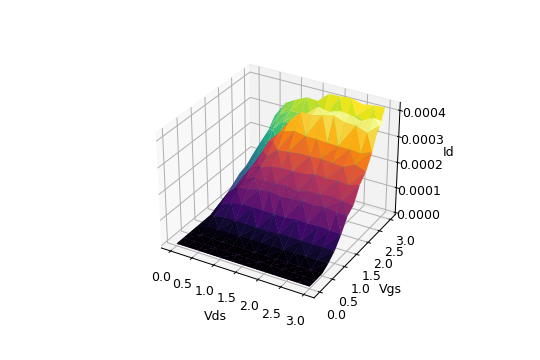

In [405]:
db = database_noise.data_to_pandas()

plot3d = db[(db['L'] == 4e-7) & (db['W'] == 4e-7) & (db['T'] == 0)]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

ax.plot_trisurf(plot3d['Vds'], 
                plot3d['Vgs'], 
                plot3d['Id'], cmap='inferno')

plot3d = db[(db['L'] == 2e-7) & (db['W'] == 2e-7) & (db['T'] == 0)]

ax.plot_trisurf(plot3d['Vds'], 
                plot3d['Vgs'], 
                plot3d['Id'], cmap ="viridis", color ="red")

<IPython.core.display.Javascript object>


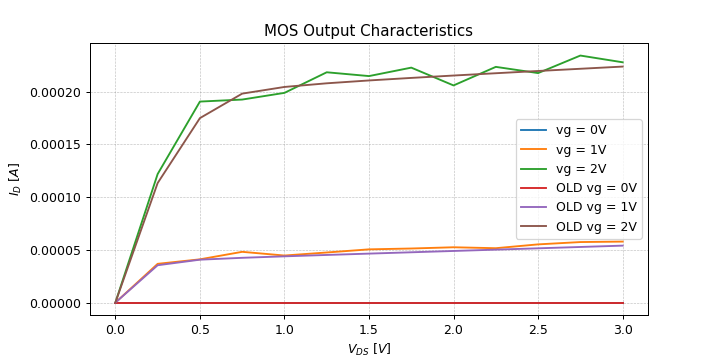

In [406]:
x = database_noise.get_vd_range()
y = []
old_y = []
vg_range = [0, 1, 2]

for vg in vg_range:
    y.append(database_noise.modeling_circuit(vg = vg, l = 2e-7, w = 2e-7, temp=0))
    old_y.append(database_simple.modeling_circuit(vg = vg, l = 2e-7, w = 2e-7, temp=0))

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, 'vg', vg_range, old_y=old_y)

<IPython.core.display.Javascript object>


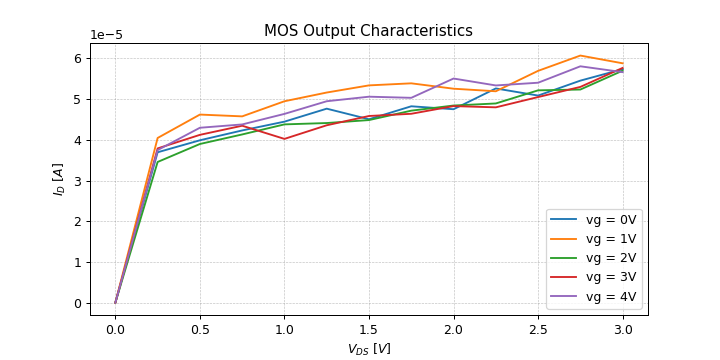

In [408]:
x = database_noise.get_vd_range()
y = []

for i in range(5):
    y.append(database_noise.modeling_circuit(vg = 1, l = 2e-7, w = 2e-7, temp=0, ))

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, x, y, 'vg', range(5))

In [409]:
data1 = database_simple.data_to_pandas()
data2 = database_noise.data_to_pandas()

print_loss(data1, data2)

max loss:  1.6650402666646664e-10
mean post-prox loss:  tf.Tensor(1.6650402666646664e-10, shape=(), dtype=float64)


Сделаем датасет с несколько "взятием точек несколько раз"

In [410]:
database_noise_5 = Database(
    model='tsmc018nfet',
    vd_slice = slice(0, 3.1, .25),
    vg_range = np.arange(0, 3.1, .25),
    l_range  = np.array([200e-9, 400e-9, 1000e-9]),
    w_range  = np.array([200e-9, 400e-9, 1000e-9]), 
    t_range  = np.arange(0, 51, 25),
    noise_l=0.03, noise_w=0.03, noise_id=0.03, noise_mob = 0.1,
    
)
database_noise_5.create_dataset(num_of_meas=5)
database_noise_5.to_csv('mosfet_noise_5.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 351/351 [00:13<00:00, 25.59it/s]


Save as mosfet_noise_5.csv


In [411]:
database_noise_5.data_to_pandas()

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-3.987083e-29
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,8.472641e-13
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.386250e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,1.993460e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.677020e-12
...,...,...,...,...,...,...
22810,2.00,3.0,1.000000e-06,1.000000e-06,50.0,4.032360e-04
22811,2.25,3.0,1.000000e-06,1.000000e-06,50.0,4.616977e-04
22812,2.50,3.0,1.000000e-06,1.000000e-06,50.0,4.286845e-04
22813,2.75,3.0,1.000000e-06,1.000000e-06,50.0,4.572081e-04


## Данные для валидации

In [ ]:
# params_range_val = _join_cross(vg_range=np.arange(0.1, 3.1, .1),
#                            l_range=np.arange(2, 11, 1) * 1e-7, 
#                            w_range=np.arange(2, 11, 1) * 1e-7, 
#                            temp_range=np.arange(0, 51, 5),
#                           )
# data_val = dataset(slice(0.1, 3.05, .1), params_range_val)
# data_val

In [17]:
dataset_val = Database(
    model='tsmc018nfet',
    vd_slice = slice(0, 3.05, .125),
    vg_range = np.arange(0, 3.05, .125),
    l_range  = np.arange(2, 11, 1) * 1e-7,
    w_range  = np.arange(2, 11, 1) * 1e-7, 
    t_range  = np.arange(0, 51, 5),
#     noise_mob = 0.05,
)
data_val = dataset_val.create_dataset()
dataset_val.to_csv('data_val_in.csv')

100%|████████████████████████████████████████████████████████████████████████████| 22275/22275 [04:02<00:00, 91.81it/s]


Save as data_val_in.csv


In [18]:
data_val.shape

(556875, 6)

In [20]:
df = dataset_val.data_to_pandas()

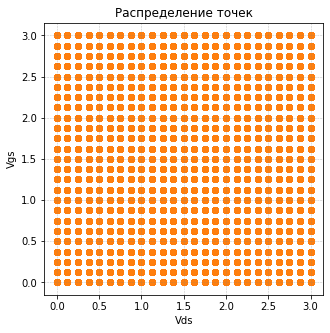

In [22]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

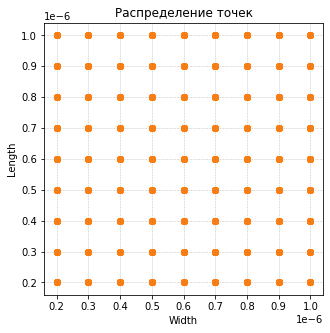

In [23]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

Получим данные для валилации вне области

In [440]:
# params_range_val = _join_cross(vg_range=np.arange(0, 6, .1),
#                            l_range=np.arange(2, 18, 3) * 1e-7, 
#                            w_range=np.arange(2, 18, 3) * 1e-7, 
#                            temp_range=np.arange(0, 25, 101),
#                           )
# data_val = dataset(slice(0, 6.05, .1), params_range_val)
# data_val

In [31]:
dataset_val_out = Database(
    model='tsmc018nfet',
    vd_slice = slice(0, 6.05, .15),
    vg_range = np.arange(0, 6.05, .15),
    l_range  = np.arange(2, 18, 3) * 1e-7,
    w_range  = np.arange(2, 18, 3) * 1e-7, 
    t_range  = np.arange(0, 101, 25),
#     noise_mob = 0.05,
)
data_val_out = dataset_val_out.create_dataset()
dataset_val_out.to_csv('data_val_out.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 7380/7380 [01:15<00:00, 97.81it/s]


Save as data_val_out.csv


In [32]:
data_val_out.shape

(302580, 6)

In [33]:
data_val_out.describe()

,Vds,Vgs,L,W,T,Id
count,302580.000000,302580.000000,3.025800e+05,3.025800e+05,302580.000000,3.025800e+05
mean,3.000000,3.000000,9.500000e-07,9.500000e-07,50.000000,4.459659e-04
std,1.774827,1.774827,5.123484e-07,5.123484e-07,35.355397,5.479167e-04
min,0.000000,0.000000,2.000000e-07,2.000000e-07,0.000000,-1.046136e-18
25%,1.500000,1.500000,5.000000e-07,5.000000e-07,25.000000,5.231339e-05
50%,3.000000,3.000000,9.500000e-07,9.500000e-07,50.000000,2.471728e-04
75%,4.500000,4.500000,1.400000e-06,1.400000e-06,75.000000,6.370231e-04
max,6.000000,6.000000,1.700000e-06,1.700000e-06,100.000000,3.978165e-03


In [66]:
# df = dataset_val_out.data_to_pandas()

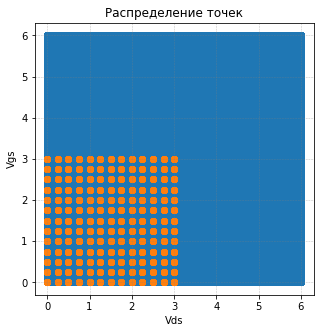

In [69]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val_out[data_val_out['T'] == data_val_out.iloc[0]['T']]['Vds']
y_val = data_val_out[data_val_out['T'] == data_val_out.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

In [ ]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val_out[data_val_out['T'] == data_val_out.iloc[0]['T']]['W']
y_val = data_val_out[data_val_out['T'] == data_val_out.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

### Построим графики

In [464]:
def get_plot(vd_slice, vg, l, w, temp):
    database_simple.vd_slice = vd_slice
    
    vds = database_simple.get_vd_range()

    ans = {
        'Vds': vds,
        'Vgs': vg ,
        'L'  : l *,
        'W'  : w *,
        'T'  : temp * ,
        'Id' : database_simple.modeling_circuit(vg = vg, l = l, w = l, temp=temp),
    }
    
#     print(ans['Vds'].shape, ans['Id'].shape)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    ax.plot(ans['Vds'], ans['Id'])
    plt.show()
    
    return pd.DataFrame(ans, index=None)

<IPython.core.display.Javascript object>


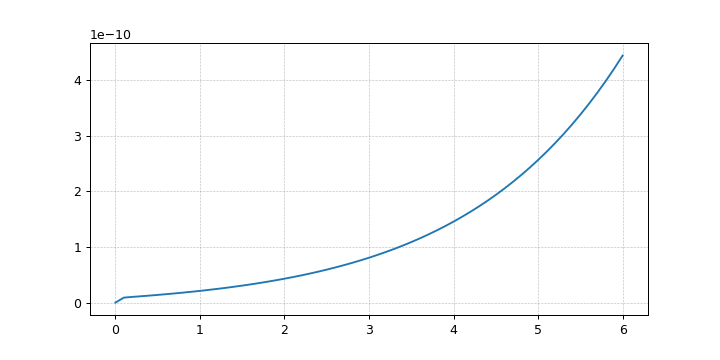

In [465]:
data_plot = get_plot(slice(0, 6.05, .1), 0.1, 2 * 1e-7, 2 * 1e-7, 25)
file_name = 'mosfet_val_1.csv'
data_plot.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


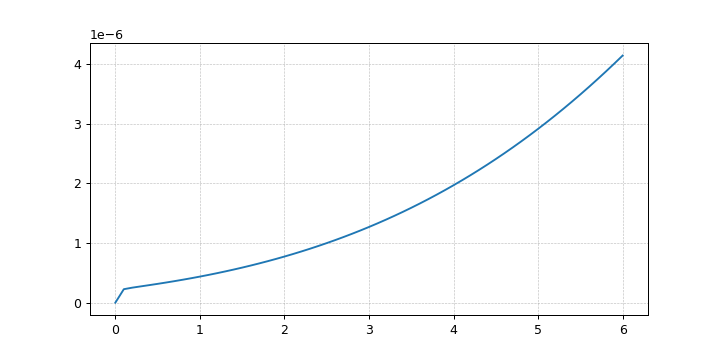

In [466]:
data_plot = get_plot(slice(0, 6.05, .1), 0.5, 2 * 1e-7, 2 * 1e-7, 25)
file_name = 'mosfet_val_2.csv'
data_plot.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


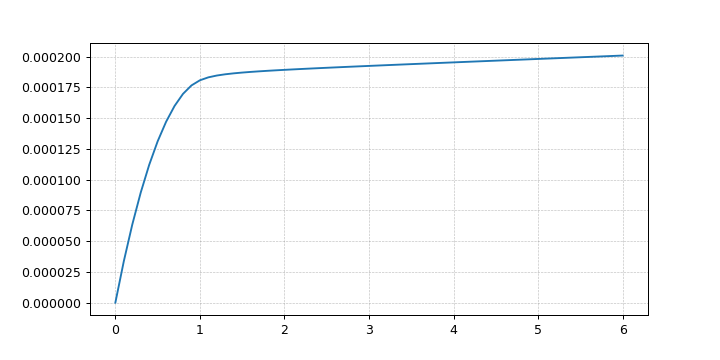

In [467]:
data_plot = get_plot(slice(0, 6.05, .1), 2, 5 * 1e-7, 5 * 1e-7, 25)
file_name = 'mosfet_val_3.csv'
data_plot.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


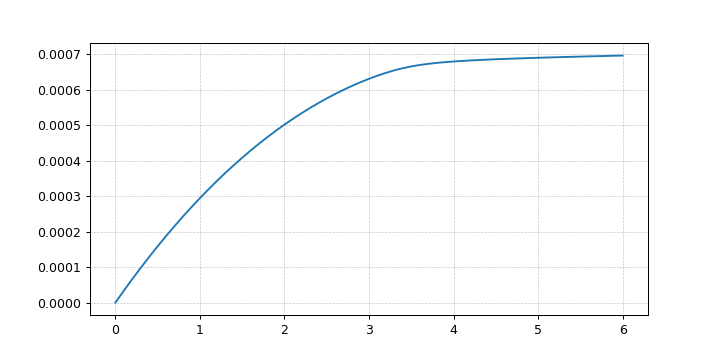

In [468]:
data_plot = get_plot(slice(0, 6.05, .1), 5, 5 * 1e-7, 5 * 1e-7, 25)
file_name = 'mosfet_val_4.csv'
data_plot.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


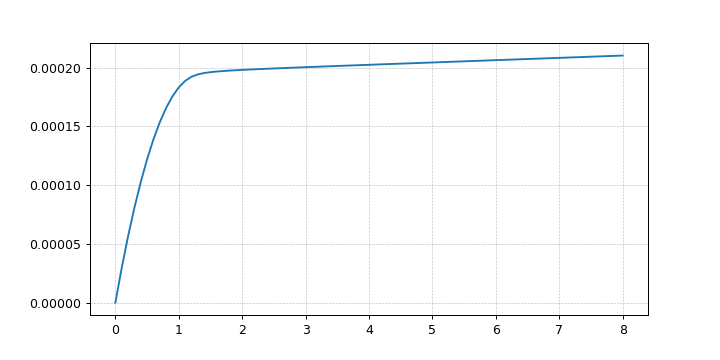

In [470]:
data_plot = get_plot(slice(0, 8.05, .1), 2, 15 * 1e-7, 15 * 1e-7, 65)
file_name = 'mosfet_val_5.csv'
data_plot.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


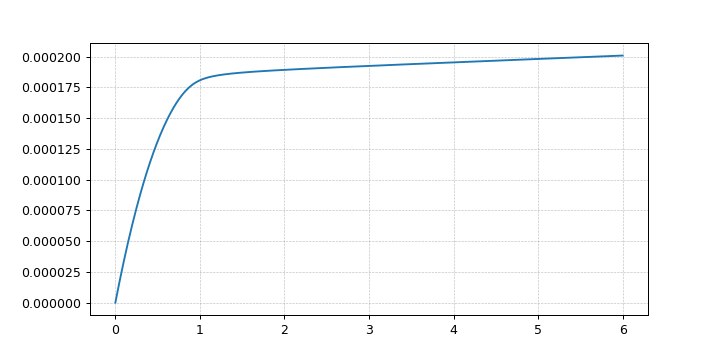

In [471]:
data_plot = get_plot(slice(0, 6.005, .01), 2, 5 * 1e-7, 5 * 1e-7, 25)
file_name = 'mosfet_val_6.csv'
data_plot.to_csv(file_name, index=None)

### Изменение способа взятия датасета

In [36]:
def mos_circuit(params=None, noise=False):
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])

    circuit.include(spice_library['tsmc018nfet'])
    if noise:
        circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', 
                       l=d['length'] * np.random.normal(1, 0.03), 
                       w=d['width'] * np.random.normal(1, 0.03),)
    else:
        circuit.M(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'])
    return circuit

print(mos_circuit())

.title MOS circuit
.include C:\Users\lario\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [37]:
def _join_cross(vg_range, l_range, w_range, temp_range):
    ans = []
    for vg in vg_range:
        for l in l_range:
            for w in w_range:
                for t in temp_range:
                    ans.append((vg, l, w, t))
    return np.array(ans)

_join_cross([1, 2], [3, 4], [5, 6], [7, 8])[:5]

array([[1, 3, 5, 7],
       [1, 3, 5, 8],
       [1, 3, 6, 7],
       [1, 3, 6, 8],
       [1, 4, 5, 7]])

In [38]:
def dataset_complicated(vd_start, vd_stop, vd_step, params_range, vg_slice_th, noise=False, num_of_meas=1, num_of_th=1):
    dataset = {'Vds': [], 'Vgs': [], 'L': [], 'W': [], 'T': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    L   = np.array([])
    W   = np.array([])
    T   = np.array([])
    Id  = np.array([])
    
    for vg, l, w, temp in tqdm(params_range):
        for _ in range(num_of_meas):
            
            l_vth = []
            for _ in range(num_of_th):
                s = (vd_stop + vd_start) / 2
                p, _ = voltage_th(vg_slice_th, s, l, w, temp, noise=noise)
                l_vth.append(-p[1]/p[0])
            vth = np.mean(ans)
            
            circuit = mos_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp}, noise=noise)
            simulator = circuit.simulator(temperature=temp, normal_temperature=25)
            
            if vg > vth:
                analysis = simulator.dc(VD=slice(vd_start, vg - vth, vd_step[0]))
                id_range = (- np.array(analysis.branches['vd']))
                vd_range = np.arange(vd_start, vg - vth, vd_step[0])
                
                analysis = simulator.dc(VD=slice(vg - vth, vd_stop, vd_step[1]))
                id_range = np.hstack((id_range, - np.array(analysis.branches['vd'])))
                vd_range = np.hstack((vd_range, np.arange(vg - vth, vd_stop, vd_step[1])))
                
            else:
                analysis = simulator.dc(VD=slice(vd_start, vd_stop, vd_step[1]))
                id_range = (- np.array(analysis.branches['vd']))
                vd_range = np.arange(vd_start, vd_stop, vd_step[1])
                
            len_id = len(id_range)
        
            if noise:
                id_range = id_range * np.random.normal(1, 0.03, len_id)
        
#             vd_range = np.arange(vd_slice.start, vd_slice.stop, vd_slice.step)
    #         print(len(vd_range), len_id, vd_range, id_range)
        
            Vds = np.hstack((Vds, vd_range))
            Vgs = np.hstack((Vgs, [vg] * len_id))
            L   = np.hstack((L, [l] * len_id))
            W   = np.hstack((W, [w] * len_id))
            T   = np.hstack((T, [temp] * len_id))
            Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['L'] = L.tolist()
    dataset['W'] = W.tolist()
    dataset['T'] = T.tolist()
    dataset['Id'] = Id.tolist()
    
    print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

    

In [42]:
def dataset(vd_slice, params_range, noise=False, num_of_meas=1):
    dataset = {'Vds': [], 'Vgs': [], 'L': [], 'W': [], 'T': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    L   = np.array([])
    W   = np.array([])
    T   = np.array([])
    Id  = np.array([])
    
    for vg, l, w, temp in tqdm(params_range):
        for _ in range(num_of_meas):
            circuit = mos_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp}, noise=noise)
            simulator = circuit.simulator(temperature=temp, normal_temperature=25)
            analysis = simulator.dc(VD=vd_slice)
        
            id_range = (- np.array(analysis.branches['vd']))
            len_id = len(id_range)
        
            if noise:
                id_range = id_range * np.random.normal(1, 0.08 / 3, len_id)
        
            vd_range = np.arange(vd_slice.start, vd_slice.stop, vd_slice.step)
    #         print(len(vd_range), len_id, vd_range, id_range)
        
            Vds = np.hstack((Vds, vd_range))
            Vgs = np.hstack((Vgs, [vg] * len_id))
            L   = np.hstack((L, [l] * len_id))
            W   = np.hstack((W, [w] * len_id))
            T   = np.hstack((T, [temp] * len_id))
            Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['L'] = L.tolist()
    dataset['W'] = W.tolist()
    dataset['T'] = T.tolist()
    dataset['Id'] = Id.tolist()
    
    print(len(dataset['Vds']), len(dataset['Vgs']), len(dataset['L']), len(dataset['Id']))
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

len(W) + len(L) = 9 (шт) -- Всего транзисторов

In [370]:
params_range_complicated = _join_cross(vg_range=np.arange(0.25, 3.1, .25),
                           l_range=np.array([200e-9, 400e-9, 1000e-9]), 
                           w_range=np.array([200e-9, 400e-9, 1000e-9]), 
                           temp_range=np.arange(0, 51, 25),
                           )
new_data = dataset_complicated(0.2, 3.1, [0.2, 0.5],
                               params_range_complicated, 
                               slice(0.1, 3.1, .4),
                               noise=True, 
                               num_of_meas=5,
                               num_of_th=3,
                              )
new_data

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [00:37<00:00,  8.76it/s]

14040 14040 14040 14040


,Vds,Vgs,L,W,T,Id
0,0.200000,0.25,2.000000e-07,2.000000e-07,0.0,2.691561e-10
1,0.700000,0.25,2.000000e-07,2.000000e-07,0.0,4.298849e-10
2,1.200000,0.25,2.000000e-07,2.000000e-07,0.0,6.215712e-10
3,1.700000,0.25,2.000000e-07,2.000000e-07,0.0,9.274083e-10
4,2.200000,0.25,2.000000e-07,2.000000e-07,0.0,1.392856e-09
...,...,...,...,...,...,...
14035,1.600000,3.00,1.000000e-06,1.000000e-06,50.0,3.695510e-04
14036,1.800000,3.00,1.000000e-06,1.000000e-06,50.0,3.812203e-04
14037,2.000000,3.00,1.000000e-06,1.000000e-06,50.0,3.909958e-04
14038,2.172169,3.00,1.000000e-06,1.000000e-06,50.0,4.031220e-04


Стало меньше точек

In [373]:
new_data.shape

(14040, 6)

In [374]:
file_name = 'mosfet_complicated.csv'
new_data.to_csv(file_name, index=None)

In [375]:
df = pd.read_csv('mosfet_complicated.csv')
df

,Vds,Vgs,L,W,T,Id
0,0.200000,0.25,2.000000e-07,2.000000e-07,0.0,2.691561e-10
1,0.700000,0.25,2.000000e-07,2.000000e-07,0.0,4.298849e-10
2,1.200000,0.25,2.000000e-07,2.000000e-07,0.0,6.215712e-10
3,1.700000,0.25,2.000000e-07,2.000000e-07,0.0,9.274083e-10
4,2.200000,0.25,2.000000e-07,2.000000e-07,0.0,1.392856e-09
...,...,...,...,...,...,...
14035,1.600000,3.00,1.000000e-06,1.000000e-06,50.0,3.695510e-04
14036,1.800000,3.00,1.000000e-06,1.000000e-06,50.0,3.812203e-04
14037,2.000000,3.00,1.000000e-06,1.000000e-06,50.0,3.909958e-04
14038,2.172169,3.00,1.000000e-06,1.000000e-06,50.0,4.031220e-04


<IPython.core.display.Javascript object>


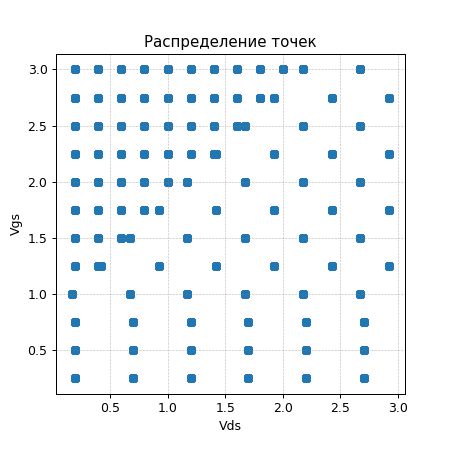

In [378]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


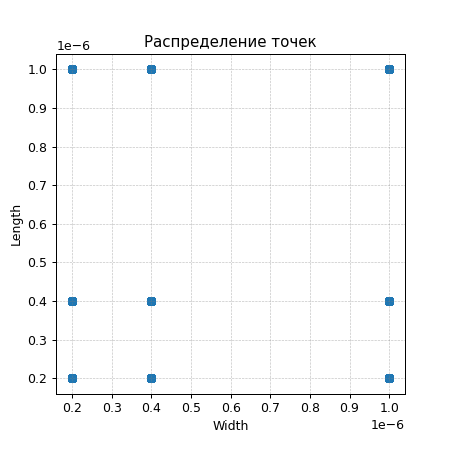

In [379]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


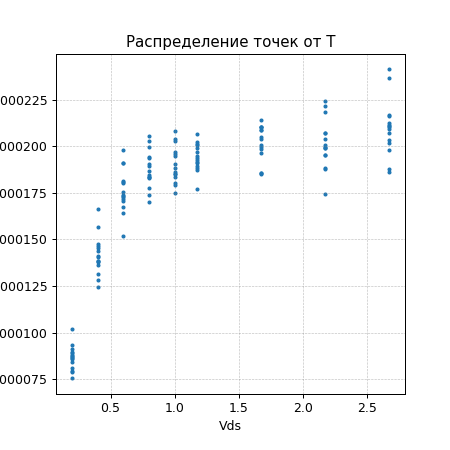

In [380]:
x = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Vds']
y = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек от T')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

### Данные для валидации

Данные внутри области обучения

In [82]:
params_range_val = _join_cross(vg_range=np.arange(0.1, 3.1, .1),
                           l_range=np.arange(2, 11, 1) * 1e-7, 
                           w_range=np.arange(2, 11, 1) * 1e-7, 
                           temp_range=np.arange(0, 51, 5),
                          )
data_val = dataset(slice(0.1, 3.05, .1), params_range_val)
data_val

100%|████████████████████████████████████████████████████████████████████████████| 26730/26730 [06:35<00:00, 67.58it/s]


,Vds,Vgs,L,W,T,Id
0,0.1,0.1,2.000000e-07,2.000000e-07,0.0,3.273073e-12
1,0.2,0.1,2.000000e-07,2.000000e-07,0.0,3.857130e-12
2,0.3,0.1,2.000000e-07,2.000000e-07,0.0,4.436923e-12
3,0.4,0.1,2.000000e-07,2.000000e-07,0.0,5.018180e-12
4,0.5,0.1,2.000000e-07,2.000000e-07,0.0,5.622239e-12
...,...,...,...,...,...,...
801895,2.6,3.0,1.000000e-06,1.000000e-06,50.0,4.162142e-04
801896,2.7,3.0,1.000000e-06,1.000000e-06,50.0,4.168972e-04
801897,2.8,3.0,1.000000e-06,1.000000e-06,50.0,4.175103e-04
801898,2.9,3.0,1.000000e-06,1.000000e-06,50.0,4.180721e-04


In [ ]:
# params_range = _join_cross(vg_range=np.arange(0.25, 3.1, .25),
#                            l_range=np.array([200e-9, 400e-9, 1000e-9]), 
#                            w_range=np.array([200e-9, 400e-9, 1000e-9]), 
#                            temp_range=np.arange(0, 51, 25),
#                            )
# data = dataset(slice(0.25, 3.1, .25), params_range, noise=True, num_of_meas=5)
# data

In [90]:
file_name = 'mosfet_val_0.csv'
data_val.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


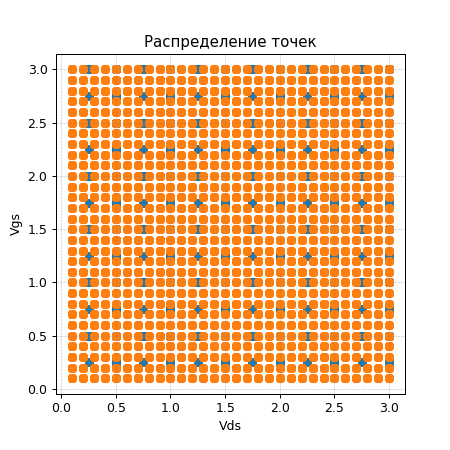

In [91]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

<IPython.core.display.Javascript object>


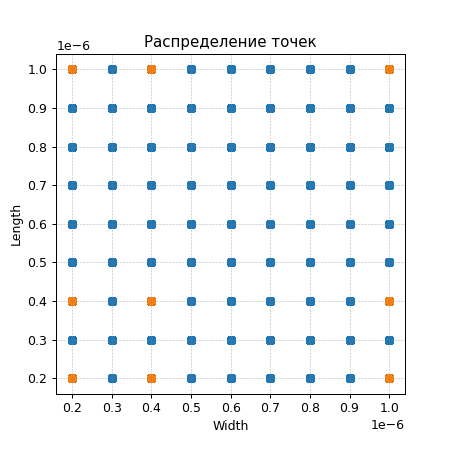

In [92]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

Валидационные данные вне области обучения

In [43]:
params_range_val = _join_cross(vg_range=np.arange(0, 6, .1),
                           l_range=np.arange(2, 18, 3) * 1e-7, 
                           w_range=np.arange(2, 18, 3) * 1e-7, 
                           temp_range=np.arange(0, 25, 101),
                          )
data_val = dataset(slice(0, 6.05, .1), params_range_val)
data_val

100%|█████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:07<00:00, 291.86it/s]


131760 131760 131760 131760


,Vds,Vgs,L,W,T,Id
0,0.0,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.1,0.0,2.000000e-07,2.000000e-07,0.0,7.807782e-13
2,0.2,0.0,2.000000e-07,2.000000e-07,0.0,5.893827e-13
3,0.3,0.0,2.000000e-07,2.000000e-07,0.0,8.094150e-13
4,0.4,0.0,2.000000e-07,2.000000e-07,0.0,1.030245e-12
...,...,...,...,...,...,...
131755,5.6,5.9,1.700000e-06,1.700000e-06,0.0,1.093667e-03
131756,5.7,5.9,1.700000e-06,1.700000e-06,0.0,1.105809e-03
131757,5.8,5.9,1.700000e-06,1.700000e-06,0.0,1.117707e-03
131758,5.9,5.9,1.700000e-06,1.700000e-06,0.0,1.129364e-03


In [62]:
file_name = 'data_val_out.csv'
data_val.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


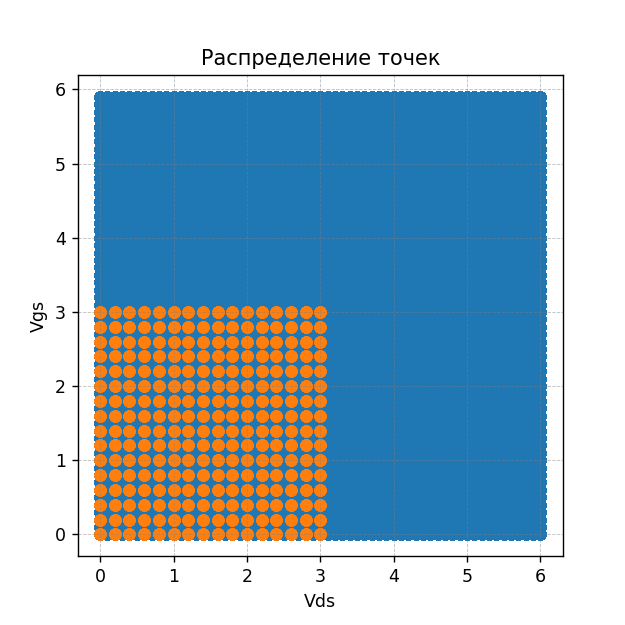

In [65]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


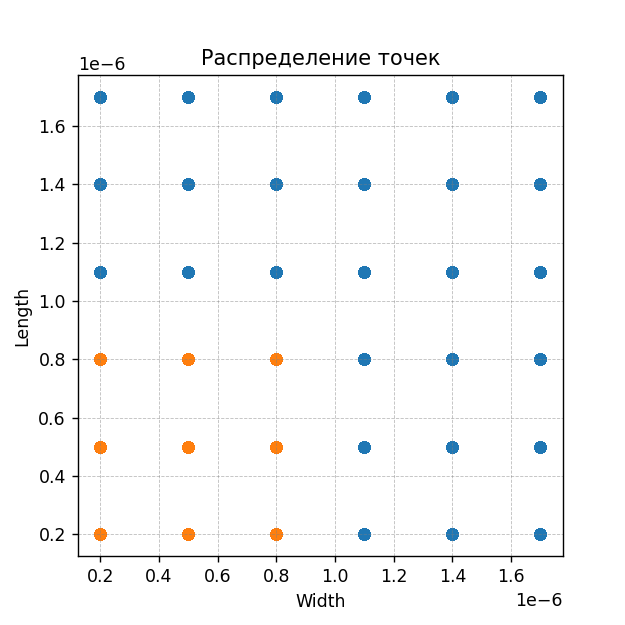

In [66]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

Данные для графиков

In [103]:
data_val = dataset(slice(0.1, 6.05, .1), [(0.1, 2 * 1e-7, 2 * 1e-7, 25)])

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.41it/s]

60 60 60 60


In [104]:
file_name = 'mosfet_val_3.csv'
data_val.to_csv(file_name, index=None)

In [105]:
data_val = dataset(slice(0, 6.05, .1), [(0.5, 2 * 1e-7, 2 * 1e-7, 25)])
file_name = 'mosfet_val_4.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.41it/s]

61 61 61 61


In [106]:
data_val = dataset(slice(0, 6.05, .1), [(2, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_5.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.42it/s]

61 61 61 61


In [108]:
data_val = dataset(slice(0, 6.05, .1), [(5, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_6.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.30it/s]

61 61 61 61


In [109]:
data_val = dataset(slice(0, 8.05, .1), [(2, 15 * 1e-7, 15 * 1e-7, 65)])
file_name = 'mosfet_val_7.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.35it/s]

81 81 81 81


In [133]:
data_val = dataset(slice(0, 6.005, .01), [(2, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_8.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.56it/s]

601 601 601 601


<IPython.core.display.Javascript object>


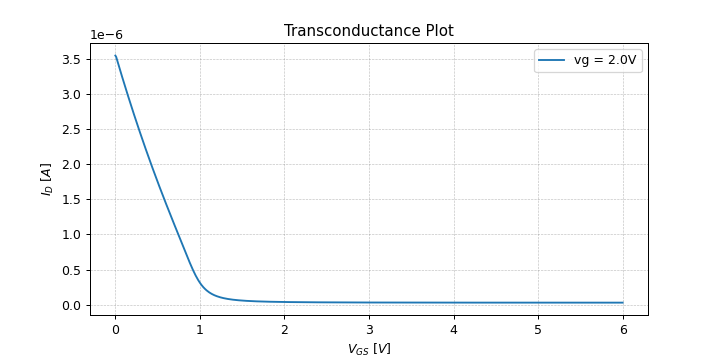

In [134]:
x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, data_val['Vds'], [data_val['Id'],], 'vg', data_val['Vgs'].unique(), func_y=np.gradient)

In [135]:
params_range_val = _join_cross(vg_range=np.arange(0.1, 5.1, .01),
                           l_range=[500e-9,], 
                           w_range=[500e-9,], 
                           temp_range=[25,],
                          )
data_val = dataset(slice(2.0, 2.1, 1), params_range_val)
file_name = 'mosfet_val_9.csv'
data_val.to_csv(file_name, index=None)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 158.10it/s]

500 500 500 500


<IPython.core.display.Javascript object>


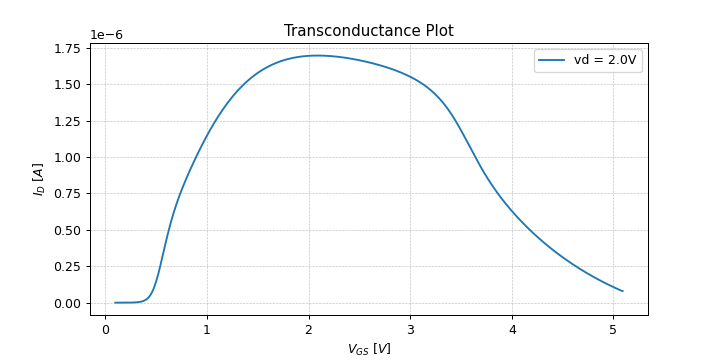

In [136]:
x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, data_val['Vgs'], [data_val['Id'],], 'vd', data_val['Vds'].unique(), func_y=np.gradient)